In [4]:
import time, sys, os
from csv_load import *
sys.path.append('./animations/')
import anim

from scipy.ndimage import median_filter
from scipy.signal import medfilt

# Loading the files
IMPORTANT NOTE: only a couple of files of Visually guided experiments are uploaded in Github due to the size of the files.  
One contains only a single trial in it.  The other contains 9 (short) trials.  

In [5]:
def df_gap(df):
    """ takes a dataframe in input (required to have the GazeX column) and measures all the NaNs Gaps in the given df.
        the first part of the returned tuple contains a list of successive gaps length, 
        the second part contains start and end coordinates of the gaps
    """
    array = [0]
    df_sub = df.loc[df['Gaze_X'].isna()]
    arridx = list(df_sub.index)
    for i,j in enumerate(arridx[:-1]):
        if arridx[i]+1 != arridx[i+1]:
            array.append(j)
            array.append(arridx[i+1])

    array.append(arridx[-1]) #includes the last element 

    na_array = []
    for i in range(1, len(array), 2):
        #print(i)
        na_array.append(array[i]-array[i-1])
    
    print(na_array, array[::2])
    return na_array, array

In [29]:
def df_split(df, gap_size = 15):
    """ aim: remove large gaps, gapi_size is the threshold value
        returns: splitted df / or just numbered (add column)
    """
    # usable for the function above
    _, splits = df_gap(df)
    na_starts = splits[::2]
    dfs = []
    for i, row in enumerate(splits[:-1]):
        dfs.append(df.loc[row:splits[i+1]])
        #print(df.loc[splits[i]:splits[i+1]])
        #print(len(df.loc[splits[i]:splits[i+1]]))
        #print(row)
        #     df['R'] == i
    
    # for i in range(1, len(splits), 2):
    #     print("{}: {}".format(splits[i-1], splits[i]-splits[i-1]))
    # return splits

    return dfs[::2]
    #print(splits)
    #return df.loc[splits[1]]
    #return (len(splits))
    

In [30]:
DIR = "../files/utf8_2/"
FILES = []
for root, dir, files in os.walk(DIR, topdown=False):
    for file in sorted(files):
        FILES.append(os.path.join(root, file))

# Median filter window sizes to test
FILTERS = [7]#, 150, 500]

for f in FILES[:1]:
    print("Processing file : ", f)
    dfs = extract_dataframes(f, set=2)
    print("Trials: ", len(dfs))
    for i in range(len(dfs)):
        print("Trial {} , NaNs gaps detected ".format(i))
        nummed_df = df_split(dfs[i])

Processing file :  ../files/utf8_2/Ball_on_Bar_-_Child_-_RIGHT_-_10_21.csv
Trials:  1
Trial 0 , NaNs gaps detected 
[534, 48, 48, 47, 48, 140, 11, 15, 125, 49, 75, 68, 1050, 11, 121, 7, 17, 11, 858, 5, 4, 1121, 69, 219, 12, 3, 7, 9, 17, 73, 15, 7, 1, 50, 69, 69, 190, 69, 69, 69, 69, 69, 68, 140, 15, 13, 2, 1059, 140, 211, 69, 69, 290, 69, 69, 69, 1369, 69, 140, 1107, 674, 190, 153, 3, 3, 1, 329, 1, 13, 9, 319, 7, 182, 154, 149, 91, 149, 69, 65, 60, 23, 6, 22, 509, 161, 11, 33, 229, 983, 1018, 211, 69, 140, 69, 69, 390, 11, 573, 1246, 332, 11, 165, 410, 11, 125, 25, 445, 50, 85, 462, 705, 495, 140, 69, 69, 140, 140, 11, 215, 37, 243, 29, 239, 31, 9, 47, 155, 95, 57, 57, 1, 39, 1, 49, 147, 45, 1, 153, 289, 113, 252, 11, 83, 7, 1, 1, 1, 101, 72, 314, 22, 18, 16, 1400, 11, 136, 91, 11, 11, 3, 23, 197, 1, 50, 15, 50, 11, 185, 300, 48, 98, 148, 269, 69, 198, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 86] [0, 536, 586, 636, 686, 736, 878, 902, 980, 1112, 1955, 2037, 2823, 3875, 4541, 4665, 4

In [36]:
np.array([len(i) for i in nummed_df])

array([ 535,   49,   49,   48,   49,  141,   12,   16,  126,   50,   76,
         69, 1051,   12,  122,    8,   18,   12,  859,    6,    5, 1122,
         70,  220,   13,    4,    8,   10,   18,   74,   16,    8,    2,
         51,   70,   70,  191,   70,   70,   70,   70,   70,   69,  141,
         16,   14,    3, 1060,  141,  212,   70,   70,  291,   70,   70,
         70, 1370,   70,  141, 1108,  675,  191,  154,    4,    4,    2,
        330,    2,   14,   10,  320,    8,  183,  155,  150,   92,  150,
         70,   66,   61,   24,    7,   23,  510,  162,   12,   34,  230,
        984, 1019,  212,   70,  141,   70,   70,  391,   12,  574, 1247,
        333,   12,  166,  411,   12,  126,   26,  446,   51,   86,  463,
        706,  496,  141,   70,   70,  141,  141,   12,  216,   38,  244,
         30,  240,   32,   10,   48,  156,   96,   58,   58,    2,   40,
          2,   50,  148,   46,    2,  154,  290,  114,  253,   12,   84,
          8,    2,    2,    2,  102,   73,  315,   

In [27]:
start_time = time.time()

DIR = "../files/utf8_2/"
FILES = []
for root, dir, files in os.walk(DIR, topdown=False):
    for file in sorted(files):
        FILES.append(os.path.join(root, file))

# Median filter window sizes to test
FILTERS = [7]#, 150, 500]

for f in FILES[10:11]:
    filename = " " + f[16:]
    dfs = extract_dataframes(f, set=2)
    print("Processing file : ", f), print("Trials: ", len(dfs))
    for i in range(len(dfs)):
        trial = Trial(dfs[i], filename, FILTERS[0])
        print('NaNs gaps detected : ')
        #print(df_gap(dfs[i]))
        print(df_split(dfs[i]))
    #     #trial.plot_movements()
    #     print("Trial {} duration : {} (s)".format((i+1), tr£ial.duration))
    #     anim.static_gaze_single_medfilt(trial, plot=True, save=False, filename=f[16:21]+str(7))
    

print("Process finished -- %s seconds --" % round((time.time() - start_time),2))

Processing file :  ../files/utf8_2/Visually_Guided_Reaching_-_Child__4_target_-_LEFT_-_10_07.csv
Trials:  9


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return 


NaNs gaps detected : 
[0, 280, 2475, 2488, 3105, 3352]

NaNs gaps detected : 
[0, 35, 52, 53, 1615, 1908, 1915, 1924, 2685, 3002, 3009, 3020, 3033, 3036, 5258, 5401, 5882, 6039, 7184, 7185]


KeyboardInterrupt: 

Further animations and plots are done with the **anim_showcase2.py** script

## Checking for the amount of missing values

In [7]:
file1 = "../files/utf8_2/Visually_Guided_Reaching_-_Child__4_target_-_LEFT_-_10_06.csv"
file2 = "../files/utf8_2/Visually_Guided_Reaching_-_Child__4_target_-_LEFT_-_10_07.csv"
dataframe1 = extract_dataframes(file1, set=2)
dataframes2 = extract_dataframes(file2, set=2)

In [8]:
def check_na(df):
    trials, nax, nay, lengths, percents = [], [], [], [], []
    for i in range(len(df)):
        trials.append(i)
        na_X, na_Y =  df[i]['Gaze_X'].isna().sum(), df[i]['Gaze_Y'].isna().sum()
        nax.append(na_X), nay.append(na_Y)
        lengths.append(len(df[i]))
        percents.append(round(na_X / len(df[i]) * 100, 2))
    d = {'Trial': trials, 'Na X': nax, 'Na Y': nay, 'Total': lengths ,'Na %': percents}
    df_na = pd.DataFrame(d)
    return df_na.set_index('Trial')

df_recap = check_na(dataframe1)
df_recap

,Na X,Na Y,Total,Na %
Trial,,,,
0,798,798,4736,16.85


Mean of missing values for the file1: 

In [9]:
df_recap['Na %'].mean()

16.85

Mean of missing values for the file2:

In [10]:
df_recap = check_na(dataframes2)
df_recap

,Na X,Na Y,Total,Na %
Trial,,,,
0,543,543,3353,16.19
1,980,980,8414,11.65
2,539,539,5857,9.20
3,1132,1132,4838,23.40
4,1299,1299,8258,15.73
5,654,654,6666,9.81
6,2355,2355,8880,26.52
7,200,200,1269,15.76
8,210,210,2586,8.12


In [11]:
df_recap['Na %'].mean()

15.153333333333332

These statistics and animations can be automatically computed for any CSV file (not all are present online).

## Filling the NAs rows

Dataframe with only gaze X,Y and Time

In [59]:
df1 = extract_dataframes(file2, set=2)[0]
df = df1[['Gaze_X', 'Gaze_Y', 'Frame time (s)']]
#for i in range (0,len(df[0]),100):
nona_len = len(df.dropna())

# Original df with the NANs : 
df
df_sub = df.loc[df['Gaze_X'].isna() ]
arridx = list(df_sub.index)
for i,j in enumerate(arridx[:-1]):
    if arridx[i]+1 != arridx[i+1]:
        print(j, arridx[i+1])


280 2475
2488 3105


NANs from 0 to 280, from 2475 to 2488, from 3105 to end

In [86]:
def df_gap(df):
    array = [0]
    df_sub = df.loc[df['Gaze_X'].isna()]
    arridx = list(df_sub.index)
    for i,j in enumerate(arridx[:-1]):
        if arridx[i]+1 != arridx[i+1]:
            array.append(j)
            array.append(arridx[i+1])

    array.append(arridx[-1])

    na_array = []
    for i in range(1, len(array), 2):
        #print(i)
        na_array.append(array[i]-array[i-1])
    return na_array, array

In [87]:
df_gap(df)

([280, 13, 247], [0, 280, 2475, 2488, 3105, 3352])

In [60]:
np.array(df_sub.index)

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
        143,  144,  145,  146,  147,  148,  149,  1

Listing the consecutives NAs

In [13]:
# Since X and Y are NAs at the same time, taking either is the same count
na_groups = df['Gaze_X'].notna().cumsum()[df['Gaze_X'].isna()]
lengths_consecutive_na = na_groups.groupby(na_groups).agg(len)
#longest_gap = lengths_consecutive_na.max()
lengths_consecutive_na

Gaze_X
0       204
8       162
960     156
3899    276
Name: Gaze_X, dtype: int64

Starting from 0 we have 204 NANs, then 8 good values, then 162 NANs, then ... 

In [14]:
sum(lengths_consecutive_na)

798

In [15]:
#df.iloc[203]
df.iloc[204]

Gaze_X            0.13665
Gaze_Y            0.58104
Frame time (s)    0.20400
Name: 204, dtype: float64

Not using the median filter from scipy because of inconsistencies in NANs handling

In [16]:
# newdf = pd.DataFrame()
# newdf['filt X'] = median_filter(df['Gaze_X'],7)
# newdf['filt Y'] = median_filter(df['Gaze_Y'],7)
# newdf['Frame time (s)'] = median_filter(df['Frame time (s)'],7)

nanmedian from numpy ignore nans values

In [17]:
def medfilt(df, f):
    """ df: raw dataframe
        f: filter size, in both directions
    """
    newdf = pd.DataFrame()
    arrx, arry = [], []
    for i in range(len(df)):
        arrx.append(np.nanmedian(df['Gaze_X'][i-f:i+f]))
        arry.append(np.nanmedian(df['Gaze_Y'][i-f:i+f]))
    newdf['X filter'], newdf['Y filter'] = arrx, arry
    newdf['Frame time (s)'] = df['Frame time (s)']

    return newdf


In [18]:
df1 = extract_dataframes(file1, set=2)[0]
medfilt(df1, 7)

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


,X filter,Y filter,Frame time (s)
0,NaN,NaN,0.000
1,NaN,NaN,0.001
2,NaN,NaN,0.002
3,NaN,NaN,0.003
4,NaN,NaN,0.004
...,...,...,...
4731,-0.179034,0.322148,4.731
4732,-0.179034,0.322183,4.732
4733,-0.179034,0.322183,4.733
4734,-0.179035,0.322183,4.734


In [19]:
filt_df = medfilt(df1, 7)
na_groups = filt_df['X filter'].notna().cumsum()[filt_df['X filter'].isna()]
na_groups.groupby(na_groups).agg(len)

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


X filter
0       198
21      149
986     143
3938    263
Name: X filter, dtype: int64

In [20]:
lengths_consecutive_na2 = na_groups.groupby(na_groups).agg(len)
sum(lengths_consecutive_na2)

753

From 798 NAs we are now at 753 with this filtering.  
With more filtering ? 

In [21]:
filt_df2 = medfilt(df1, 30)
na_groups = filt_df2['X filter'].notna().cumsum()[filt_df2['X filter'].isna()]
lengths_consecutive_na3 = na_groups.groupby(na_groups).agg(len)
sum(lengths_consecutive_na3)

592

Lower, as expected

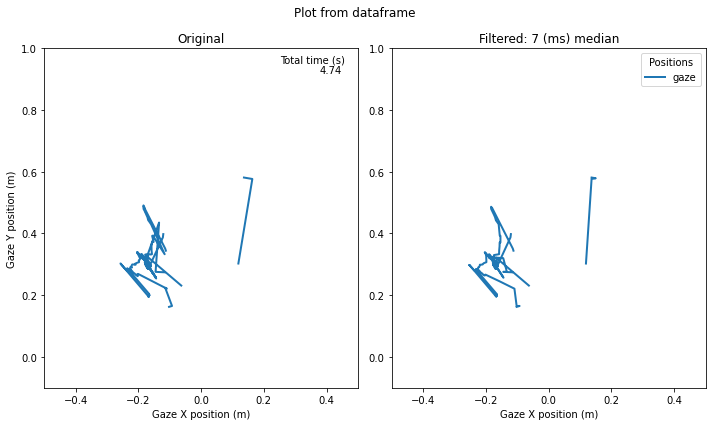

In [22]:
anim.static_simple_medfilt(df1, filt_df, plot=True, save=False)
#         trial = Trial(dfs[i], filename)
#         print(trial.duration)
#         for s in FILTERS:
#             #anim.animate_gaze_single_medfilt(trial, plot=True, save=False, filter=s, speed=1, filename=f[16:21]+str(s))
#             anim.static_gaze_single_medfilt(trial, plot=False, save=True, filter=s,filename=f[16:21]+str(s))
#     #plt.close()

In [25]:
start_time = time.time()

DIR = "../files/utf8_2/"
FILES = []
for root, dir, files in os.walk(DIR, topdown=False):
    for file in sorted(files):
        FILES.append(os.path.join(root, file))

# Median filter window sizes to test
FILTERS = [90]#, 150, 500]

for f in FILES[:1]:
    filename = " " + f[16:]
    dfs = extract_dataframes(f, set=2)
    print("Processing file : ", f), print("Trials: ", len(dfs))
    # for i in range(len(dfs)):
    #     trial = Trial(dfs[i], filename, 7)
    #     #trial.plot_movements()
    #     print("Trial {} duration : {} (s)".format((i+1), trial.duration))
    #     for s in FILTERS:
    #         # animations only work outside of jupyter notebooks, but can still be saved here
    #         anim.animate_gaze_single_medfilt(trial, plot=False, save=True, speed=50, filename=f[16:21]+str(s))
    #         anim.static_gaze_single_medfilt(trial, plot=False, save=True, speed =2, filter=7,filename=f[16:21]+str(s))
    


print("Process finished -- %s seconds --" % round((time.time() - start_time),2))

Processing file :  ../files/utf8_2/Ball_on_Bar_-_Child_-_RIGHT_-_10_21.csv
Trials:  1
Process finished -- 2.08 seconds --


### Experimental, to be deleted

In [26]:
newdf = pd.DataFrame()
arr = []
for i in range(len(df)):
    arr.append(np.nanmedian(df['Gaze_X'][i-7:i+6]))

newdf['filt 2'] = arr
nona_len # 3938

len(newdf.dropna())


3979

In [ ]:
x = df['Gaze_X']
x = x[np.logical_not(np.isnan(x))]
fx = medfilt(df['Gaze_X'], 7)
fx = fx[np.logical_not(np.isnan(fx))]
np.shape(fx)

(3938,)

In [ ]:
newdf['filtered'].isnull().values

array([ True,  True,  True, ..., False, False, False])

In [ ]:
# def medfilt(array, f):
#     arr = []
#     for i, j in enumerate(array[:f]):
#         arr.append(np.median(array[:i+f]))
#     for i, j in enumerate(array[f:-f]):
#         #print(array[i:i+2*f])#, j)
#         arr.append(np.median(array[i:i+2*f+1]))
#         print(array[i:i+2*f+1])
#     for i, j in enumerate(array[-f:]):
#         print((array[i-f:]))
#     return arr


# x = [4,5,6,10,3,2,8,9]
# a = medfilt(x, 2)
# a
# #len(a)

In [ ]:
np.shape(np.where(df['Gaze_X'].isnull()))

(1, 798)

In [ ]:
np.shape(np.where(newdf['filtered'].isnull()))

(1, 795)

In [ ]:

z = (np.random.rand(10)*10).round()
z

array([ 4.,  3.,  7.,  5.,  9.,  0.,  0., 10.,  8.,  1.])

In [ ]:
median_filter(z,5)

array([4., 4., 5., 5., 5., 5., 8., 1., 1., 8.])

In [ ]:
def check_na(df):
    trials, nax, nay, lengths, percents = [], [], [], [], []
    for i in range(len(df)):
        trials.append(i)
        na_X, na_Y =  df[i]['Gaze_X'].isna().sum(), df[i]['Gaze_Y'].isna().sum()
        nax.append(na_X), nay.append(na_Y)
        lengths.append(len(df[i]))
        percents.append(round(na_X / len(df[i]) * 100, 2))
    d = {'Trial': trials, 'Na X': nax, 'Na Y': nay, 'Total': lengths ,'Na %': percents}
    df_na = pd.DataFrame(d)
    return df_na.set_index('Trial')